In [25]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from PIL import Image
import shutil
import torch
import torch.optim as optim
from Callbacks import EarlyStopping
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from caps_cropped_model import CapsuleNetwork, CapsuleLoss, display_images

from caps_utils import CAPS_Productive_Dataset, display_data_loader_batch, TransformDataset
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics 8.3.57  Python-3.12.3 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Setup complete  (12 CPUs, 31.9 GB RAM, 322.2/397.5 GB disk)


## YOLO1

### Load Dataset YOLO1

In [26]:
image_folder="D:/Datasets/YOLO_1_Dataset/test/images"
label_folder="D:/Datasets/YOLO_1_Dataset/test/labels"

test_images= [f for f in os.listdir(image_folder) if f.endswith((".jpeg", ".JPEG"))]
test_labels= [f for f in os.listdir(label_folder) if f.endswith((".txt"))]
print(f"Gefundene testbilder: {len(test_images)}")
print(f"Gefundene testlabels: {len(test_labels)}")

image_bbox_pairs = [
                    (os.path.join(image_folder, img), os.path.join(label_folder,img.replace(".jpeg",".txt").replace(".JPEG",".txt")))
                    for img in  test_images
                    if img.replace(".jpeg",".txt").replace(".JPEG",".txt") in test_labels
]
print(f"Gefundene Paare: {len(image_bbox_pairs)}")


Gefundene testbilder: 5370
Gefundene testlabels: 5370
Gefundene Paare: 5370


In [27]:
image_bbox_pairs

[('D:/Datasets/YOLO_1_Dataset/test/images\\1.3.6.1.4.1.14519.5.2.1.6279.6001.104507274032170320323347152411.jpeg',
  'D:/Datasets/YOLO_1_Dataset/test/labels\\1.3.6.1.4.1.14519.5.2.1.6279.6001.104507274032170320323347152411.txt'),
 ('D:/Datasets/YOLO_1_Dataset/test/images\\1.3.6.1.4.1.14519.5.2.1.6279.6001.104863864417205674007098486529.jpeg',
  'D:/Datasets/YOLO_1_Dataset/test/labels\\1.3.6.1.4.1.14519.5.2.1.6279.6001.104863864417205674007098486529.txt'),
 ('D:/Datasets/YOLO_1_Dataset/test/images\\1.3.6.1.4.1.14519.5.2.1.6279.6001.108828997377593078753121028952.jpeg',
  'D:/Datasets/YOLO_1_Dataset/test/labels\\1.3.6.1.4.1.14519.5.2.1.6279.6001.108828997377593078753121028952.txt'),
 ('D:/Datasets/YOLO_1_Dataset/test/images\\1.3.6.1.4.1.14519.5.2.1.6279.6001.109466173635014704200062503592.jpeg',
  'D:/Datasets/YOLO_1_Dataset/test/labels\\1.3.6.1.4.1.14519.5.2.1.6279.6001.109466173635014704200062503592.txt'),
 ('D:/Datasets/YOLO_1_Dataset/test/images\\1.3.6.1.4.1.14519.5.2.1.6279.6001.109

In [28]:
def load_ground_truth(file_path, image_shape):
    h,w = image_shape[:2]
    boxes=[]

    with open(file_path, "r") as f:
        for line in f.readlines():
            class_id,x_center, y_center, width, height = map(float, line.strip().split())

            x_min = int((x_center - width/2)*w)
            y_min = int((y_center - width/2)*h)
            x_max = int((x_center + width/2)*w)
            y_max = int((y_center + width/2)*h)
        
            boxes.append([x_min,y_min,x_max,y_max])
    return boxes

### Predict Bounding Boxes with YOLO1

In [29]:
model=YOLO("YOLO1/1/weights/best.pt")
print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_

In [30]:
predictions_yolo1={}
ground_truths={}

for image_path, bbox_path in image_bbox_pairs:
    image = Image.open(image_path)

    image_np = np.array(image)

    gt_boxes = load_ground_truth(bbox_path, image_np.shape)
    ground_truths[os.path.basename(image_path)] = gt_boxes

    results = model(image_np)

    boxes = results[0].boxes.xyxy.cpu().numpy()
    scores = results[0].boxes.conf.cpu().numpy()
    classes = results[0].boxes.cls.cpu().numpy()

    predictions_yolo1[os.path.basename(image_path)]= {
        "boxes": boxes,
        "scores": scores,
        "classes": classes
    }


0: 512x512 (no detections), 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 14.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 9.0ms
Speed: 0.8ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 10.0ms
Speed: 0.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 9.0ms
Speed: 1.0ms preprocess, 9.0ms infere

In [31]:
len(predictions_yolo1)

5370

In [32]:
predictions_yolo1

{'1.3.6.1.4.1.14519.5.2.1.6279.6001.104507274032170320323347152411.jpeg': {'boxes': array([], shape=(0, 4), dtype=float32),
  'scores': array([], dtype=float32),
  'classes': array([], dtype=float32)},
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.104863864417205674007098486529.jpeg': {'boxes': array([], shape=(0, 4), dtype=float32),
  'scores': array([], dtype=float32),
  'classes': array([], dtype=float32)},
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.108828997377593078753121028952.jpeg': {'boxes': array([], shape=(0, 4), dtype=float32),
  'scores': array([], dtype=float32),
  'classes': array([], dtype=float32)},
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.109466173635014704200062503592.jpeg': {'boxes': array([], shape=(0, 4), dtype=float32),
  'scores': array([], dtype=float32),
  'classes': array([], dtype=float32)},
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.109626634592628652877975591041.jpeg': {'boxes': array([], shape=(0, 4), dtype=float32),
  'scores': array([], dtype=float32),
  'classes': array([], dtype=f

In [33]:
len(ground_truths)

5370

In [34]:
ground_truths

{'1.3.6.1.4.1.14519.5.2.1.6279.6001.104507274032170320323347152411.jpeg': [],
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.104863864417205674007098486529.jpeg': [],
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.108828997377593078753121028952.jpeg': [],
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.109466173635014704200062503592.jpeg': [],
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.109626634592628652877975591041.jpeg': [],
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.109710522872080626618036223042.jpeg': [],
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.116069400930896573799773712313.jpeg': [],
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.116221631153879627914984470663.jpeg': [],
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.118597469360280284504244918386.jpeg': [],
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.121898080754492407159861475149.jpeg': [],
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.138539218439961612704732946102.jpeg': [],
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.142868044429387263567069942743.jpeg': [],
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.1461657008134969218360078604

In [36]:
def calculate_iou(box1, box2):
    """
    Berechnet die Intersection over Union (IoU) zwischen zwei Bounding Boxes.
    
    Parameter:
    - box1: [x_min, y_min, x_max, y_max] für die erste Box
    - box2: [x_min, y_min, x_max, y_max] für die zweite Box

    Rückgabewert:
    - IoU-Wert zwischen 0 und 1
    """
    # Koordinaten der Schnittmenge (überlappender Bereich)
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Breite und Höhe der Schnittmenge berechnen
    intersection_width = max(0, x2 - x1)
    intersection_height = max(0, y2 - y1)
    intersection_area = intersection_width * intersection_height

    # Flächen der beiden Boxen berechnen
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Union = Summe der Flächen minus die Schnittfläche
    union_area = box1_area + box2_area - intersection_area

    # Vermeidung von Division durch 0
    return intersection_area / union_area if union_area > 0 else 0
def evaluate_predictions(predictions, ground_truths, iou_threshold=0.5):
    """
    Evaluierung der Bounding Box Vorhersagen anhand der Ground Truth.

    Parameter:
    - predictions: Dictionary mit Vorhersagen (Dateiname -> {'boxes': [...], 'scores': [...], 'classes': [...]})
    - ground_truths: Dictionary mit Ground Truth-Boxen (Dateiname -> [[x1, y1, x2, y2], ...])
    - iou_threshold: Schwellwert für IoU zur Übereinstimmung (Standard = 0.5)

    Rückgabewert:
    - True Positives (TP), False Positives (FP), False Negatives (FN), True Negatives (TN)
    """
    tp, fp, fn, tn = 0, 0, 0, 0

    for image_id, prediction in predictions.items():
        pred_boxes = prediction['boxes']
        gt_boxes = ground_truths.get(image_id, [])
        
        # Fall 1: Weder Vorhersagen noch Ground Truth → True Negative (TN)
        if len(pred_boxes) == 0 and len(gt_boxes) == 0:
            tn += 1
            continue

        # Fall 2: Keine Vorhersage, aber Ground Truth vorhanden → False Negative (FN)
        if len(pred_boxes) == 0 and len(gt_boxes) > 0:
            fn += len(gt_boxes)
            continue

        # Fall 3: Vorhersagen vorhanden, aber keine Ground Truth → False Positive (FP)
        if len(pred_boxes) > 0 and len(gt_boxes) == 0:
            fp += len(pred_boxes)
            continue
        
        # Fall 4: Sowohl Vorhersagen als auch Ground Truth vorhanden
        matched = set()  # Um doppelte Zuordnungen zu vermeiden
        
        for pred_box in pred_boxes:
            best_iou = 0
            best_gt_idx = -1
            
            for idx, gt_box in enumerate(gt_boxes):
                iou = calculate_iou(pred_box, gt_box)
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            # Falls IoU-Schwelle überschritten und Ground Truth nicht bereits gematcht → TP
            if best_iou >= iou_threshold and best_gt_idx not in matched:
                tp += 1
                matched.add(best_gt_idx)
            else:
                fp += 1  # Nicht übereinstimmende Vorhersage ist False Positive

        # Alle nicht gematchten Ground Truth Boxen sind False Negatives
        fn += len(gt_boxes) - len(matched)

    return tp, fp, fn, tn
tp, fp, fn, tn = evaluate_predictions(predictions_yolo1, ground_truths)



# Metriken berechnen
accuracy = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Ergebnisse ausgeben
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


True Positives (TP): 2475
False Positives (FP): 290
True Negatives (TN): 2604
False Negatives (FN): 225
Accuracy: 0.9079
Precision: 0.8951
Recall: 0.9167
F1-Score: 0.9058


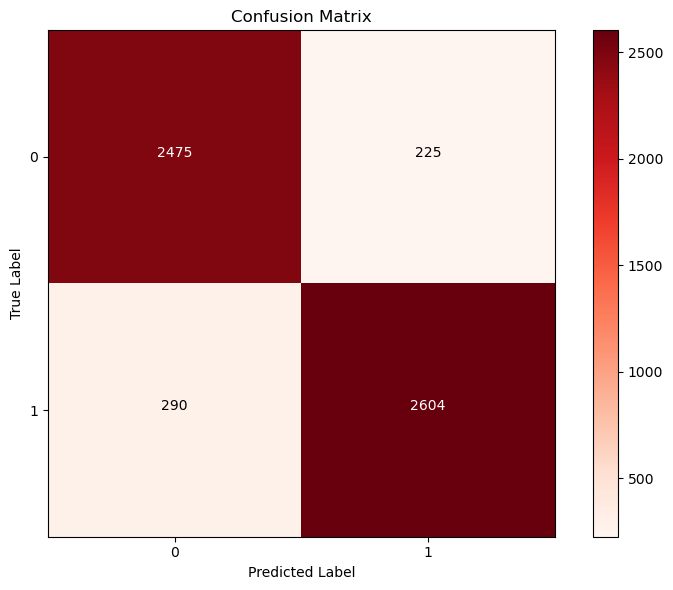

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def display_confusion_matrix(tp, fp, tn, fn):
    # Erstellen der Confusion-Matrix aus TP, FP, TN, FN
    cm = np.array([[tp, fn], 
                   [fp, tn]])

    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Reds)
    plt.title("Confusion Matrix")
    plt.colorbar()

    # Achsenbeschriftungen für Binärklassifikation (0 = Negative, 1 = Positive)
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['0', '1'])
    plt.yticks(tick_marks, ['0', '1'])

    # Einfügen der Werte in die Matrix mit Farbkontrast für bessere Sichtbarkeit
    threshold = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]}", 
                 horizontalalignment="center", 
                 color="white" if cm[i, j] > threshold else "black")

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

# Aufruf der Funktion zur Anzeige der Confusion-Matrix
display_confusion_matrix(tp, fp, tn, fn)

In [38]:
iou_threshold = 0.5  # Mindest-IoU-Wert für eine erfolgreiche Erkennung (True Positive)
scores_list = []     # Liste zur Speicherung der Scores
tp_fp_list = []      # Liste zur Speicherung von TP (1) / FP (0)

# Iteration über alle vorhergesagten Bilder
for img_id, pred in predictions_yolo1.items():
    pred_boxes = pred['boxes']  # Extrahiere vorhergesagte Bounding-Boxen
    pred_scores = pred['scores']  # Extrahiere Confidence-Scores
    
    gt_boxes = ground_truths.get(img_id, [])  # Lade die Ground-Truth-Boxen (falls vorhanden)

    # Falls es keine Ground-Truth für das Bild gibt, sind alle Vorhersagen False Positives (FP)
    if len(gt_boxes) == 0:
        scores_list.extend(pred_scores)  # Füge Scores hinzu
        tp_fp_list.extend([0] * len(pred_scores))  # Füge False Positives hinzu (da keine Ground-Truth)
        continue  # Zum nächsten Bild springen
    
    detected = [False] * len(gt_boxes)  # Markierung, ob Ground-Truth-Boxen schon erkannt wurden
    
    # Vergleiche jede vorhergesagte Box mit allen Ground-Truth-Boxen
    for i, box in enumerate(pred_boxes):
        best_iou = 0
        best_gt_idx = -1

        # Berechne IoU mit jeder Ground-Truth-Box
        for j, gt_box in enumerate(gt_boxes):
            iou = calculate_iou(box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = j
        
        # Wenn die beste Übereinstimmung über dem IoU-Schwellenwert liegt, ist es ein TP
        if best_iou >= iou_threshold and not detected[best_gt_idx]:
            scores_list.append(pred_scores[i])  # Speichere den Score
            tp_fp_list.append(1)  # True Positive (TP)
            detected[best_gt_idx] = True  # Diese Ground-Truth-Box wurde erkannt
        else:
            scores_list.append(pred_scores[i])  # Speichere den Score
            tp_fp_list.append(0)  # False Positive (FP)

# Jetzt haben wir zwei separate Listen
scores_list=np.array(scores_list)
tp_fp_list=np.array(tp_fp_list)


In [39]:
from sklearn.metrics import average_precision_score

average_precision_score(tp_fp_list, scores_list)

0.9553968691807033

### Crop and Save Images

In [13]:
# Verzeichnisse
image_dir = "D:/Datasets/YOLO_1_Dataset/test/images"  # Ordner mit den Originalbildern
output_dir = "D:/Datasets/Productive_YOLO1/Predicted_Nodules"  # Ordner, wo die gecroppten Bilder gespeichert werden
os.makedirs(output_dir, exist_ok=True)

def crop_and_save_image(image_path, boxes, output_name_base):
    # Bild öffnen
    image = Image.open(image_path).convert("RGB")
    
    # Nur die höchste Box verwenden
    if len(boxes) > 0:
        x_min, y_min, x_max, y_max = map(int, boxes[0])  # Koordinaten runden und in int umwandeln
        width = x_max - x_min
        height = y_max - y_min
        max_side = max(width, height)
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        x_min = max(0, x_center - max_side / 2)
        y_min = max(0, y_center - max_side / 2)
        x_max = min(image.width, x_center + max_side / 2)
        y_max = min(image.height, y_center + max_side / 2)
        x_min, x_max = int(x_min), int(x_max)
        y_min, y_max = int(y_min), int(y_max)
        cropped_image = image.crop((x_min, y_min, x_max, y_max)) 
        cropped_image = cropped_image.resize((128, 128), Image.LANCZOS)
        
        # Speicherpfad für das gecroppte Bild
        cropped_image_path = os.path.join(output_dir, f"{output_name_base}_crop.jpg")
        cropped_image.save(cropped_image_path)
        print(f"Saved cropped image: {cropped_image_path}")

for image_name, info in predictions_yolo1.items():
    image_path = os.path.join(image_dir, image_name)
    output_name_base = os.path.splitext(image_name)[0]  # Basisname ohne Erweiterung
    
    # Nur croppen und speichern, wenn Bounding Boxes vorhanden sind
    if len(info['boxes']) > 0:
        # Index der Box mit dem höchsten Score finden
        highest_score_idx = int(np.argmax(info['scores']))
        # Nur die höchste Box verwenden
        highest_box = info['boxes'][highest_score_idx:highest_score_idx+1]
        crop_and_save_image(image_path, highest_box, output_name_base)


Saved cropped image: D:/Datasets/Productive_YOLO1/Predicted_Nodules\1.3.6.1.4.1.14519.5.2.1.6279.6001.479296688495663090411829052528_crop.jpg
Saved cropped image: D:/Datasets/Productive_YOLO1/Predicted_Nodules\1.3.6.1.4.1.14519.5.2.1.6655.2359.100048574870269820953143768196_crop.jpg
Saved cropped image: D:/Datasets/Productive_YOLO1/Predicted_Nodules\1.3.6.1.4.1.14519.5.2.1.6655.2359.100072635488116034651642445239_crop.jpg
Saved cropped image: D:/Datasets/Productive_YOLO1/Predicted_Nodules\1.3.6.1.4.1.14519.5.2.1.6655.2359.100156561188861970258198914981_crop.jpg
Saved cropped image: D:/Datasets/Productive_YOLO1/Predicted_Nodules\1.3.6.1.4.1.14519.5.2.1.6655.2359.100423729079097357558203729845_crop.jpg
Saved cropped image: D:/Datasets/Productive_YOLO1/Predicted_Nodules\1.3.6.1.4.1.14519.5.2.1.6655.2359.100436650956340012584392599393_crop.jpg
Saved cropped image: D:/Datasets/Productive_YOLO1/Predicted_Nodules\1.3.6.1.4.1.14519.5.2.1.6655.2359.100546121805341655431102542094_crop.jpg
Saved 

### Save predicted Non-Nodules

In [14]:
import os
import shutil
import numpy as np

# Zielordner erstellen
non_nodule_folder = 'D:/Datasets/Productive_YOLO1/Predicted_Non_Nodule'
os.makedirs(non_nodule_folder, exist_ok=True)

# Verzeichnis mit den Originalbildern
source_directory = 'D:/Datasets/YOLO_1_Dataset/test/images'

# Beispiel-Datenstruktur, die du angegeben hast

# Funktion, um Bilder ohne Boundingbox zu kopieren
def copy_images_without_bboxes(predictions, source_directory, destination_folder):
    for file_name, data in predictions.items():
        # Überprüfen, ob das "boxes" Array leer ist
        if data['boxes'].shape[0] == 0:
            # Bildpfad
            source_image_path = os.path.join(source_directory, file_name)
            
            # Prüfen, ob das Bild existiert
            if os.path.exists(source_image_path):
                # Zielpfad für das Kopieren
                shutil.copy(source_image_path, os.path.join(destination_folder, file_name))
                print(f"Kopiert: {source_image_path} -> {destination_folder}")
            else:
                print(f"Bild nicht gefunden: {file_name}")

# Bilder ohne Boundingbox kopieren
copy_images_without_bboxes(predictions_yolo1, source_directory, non_nodule_folder)


Kopiert: D:/Datasets/YOLO_1_Dataset/test/images\1.3.6.1.4.1.14519.5.2.1.6279.6001.104507274032170320323347152411.jpeg -> D:/Datasets/Productive_YOLO1/Predicted_Non_Nodule
Kopiert: D:/Datasets/YOLO_1_Dataset/test/images\1.3.6.1.4.1.14519.5.2.1.6279.6001.104863864417205674007098486529.jpeg -> D:/Datasets/Productive_YOLO1/Predicted_Non_Nodule
Kopiert: D:/Datasets/YOLO_1_Dataset/test/images\1.3.6.1.4.1.14519.5.2.1.6279.6001.108828997377593078753121028952.jpeg -> D:/Datasets/Productive_YOLO1/Predicted_Non_Nodule
Kopiert: D:/Datasets/YOLO_1_Dataset/test/images\1.3.6.1.4.1.14519.5.2.1.6279.6001.109466173635014704200062503592.jpeg -> D:/Datasets/Productive_YOLO1/Predicted_Non_Nodule
Kopiert: D:/Datasets/YOLO_1_Dataset/test/images\1.3.6.1.4.1.14519.5.2.1.6279.6001.109626634592628652877975591041.jpeg -> D:/Datasets/Productive_YOLO1/Predicted_Non_Nodule
Kopiert: D:/Datasets/YOLO_1_Dataset/test/images\1.3.6.1.4.1.14519.5.2.1.6279.6001.109710522872080626618036223042.jpeg -> D:/Datasets/Productive_Y

In [50]:
def get_file_list_without_suffix(folder_path, suffix="_crop.jpg"):
    """
    Erstellt eine Liste von Dateinamen ohne einen angegebenen Suffix.
    
    Args:
        folder_path (str): Pfad zum Ordner mit den Dateien.
        suffix (str): Der zu entfernende Suffix (Standard: "_crop.jpg").
    
    Returns:
        list: Liste der Dateinamen ohne den angegebenen Suffix.
    """
    # Überprüfen, ob der Ordner existiert
    if not os.path.exists(folder_path):
        print(f"Ordner existiert nicht: {folder_path}")
        return []

    # Liste erstellen
    file_list = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(suffix):
            base_name = file_name.replace(suffix, "")
            file_list.append(base_name)

    return file_list

# 
folder_path = "D:/Datasets/Productive_YOLO1/Predicted_Nodules"  

# Liste der Dateien abrufen
file_list = get_file_list_without_suffix(folder_path)

# Ergebnis ausgeben
if file_list:
    print("Dateien ohne '_crop.jpg':")
    for file in file_list:
        print(file)
else:
    print("Keine Dateien gefunden oder der Ordner ist leer.")


Dateien ohne '_crop.jpg':
1.3.6.1.4.1.14519.5.2.1.6279.6001.479296688495663090411829052528
1.3.6.1.4.1.14519.5.2.1.6655.2359.100048574870269820953143768196
1.3.6.1.4.1.14519.5.2.1.6655.2359.100072635488116034651642445239
1.3.6.1.4.1.14519.5.2.1.6655.2359.100156561188861970258198914981
1.3.6.1.4.1.14519.5.2.1.6655.2359.100423729079097357558203729845
1.3.6.1.4.1.14519.5.2.1.6655.2359.100436650956340012584392599393
1.3.6.1.4.1.14519.5.2.1.6655.2359.100546121805341655431102542094
1.3.6.1.4.1.14519.5.2.1.6655.2359.100711050613761855156496841207
1.3.6.1.4.1.14519.5.2.1.6655.2359.101000900610617184701526787276
1.3.6.1.4.1.14519.5.2.1.6655.2359.101291121425729144303985968215
1.3.6.1.4.1.14519.5.2.1.6655.2359.101387392164687470019399118073
1.3.6.1.4.1.14519.5.2.1.6655.2359.101552676343802219174468968616
1.3.6.1.4.1.14519.5.2.1.6655.2359.101634367634299367585297122422
1.3.6.1.4.1.14519.5.2.1.6655.2359.102036617799935254529214401373
1.3.6.1.4.1.14519.5.2.1.6655.2359.102061873219359169760863971555

In [51]:
len(file_list)

2733

In [53]:
def get_file_list(folder_path):
    return [os.path.splitext(f)[0] for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Example usage
folder_path = "D:/Datasets/Productive_YOLO1/Predicted_Non_Nodule"
non_nodule_yolo_file_list = get_file_list(folder_path)
non_nodule_yolo_file_list

['1.3.6.1.4.1.14519.5.2.1.6279.6001.104507274032170320323347152411',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.104863864417205674007098486529',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.108828997377593078753121028952',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.109466173635014704200062503592',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.109626634592628652877975591041',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.109710522872080626618036223042',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.116069400930896573799773712313',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.116221631153879627914984470663',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.118597469360280284504244918386',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.121898080754492407159861475149',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.138539218439961612704732946102',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.142868044429387263567069942743',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.146165700813496921836007860426',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.148586842468211746670727536686',
 '1.3.6.1.4.1.14519.5.2.1.6279.600

In [55]:
# Zielverzeichnis für die kopierten Labels
yolo_predicted_nodule_labels = 'D:/Datasets/Productive_YOLO1/predicted_nodule_labels'
yolo_predicted_non_nodule_labels = 'D:/Datasets/Productive_YOLO1/predicted_non_nodule_labels'
os.makedirs(yolo_predicted_nodule_labels, exist_ok=True)
os.makedirs(yolo_predicted_non_nodule_labels, exist_ok=True)

# Verzeichnis mit den Original-Labels
source_directory = 'D:/Datasets/YOLO_1_Dataset/test/labels'
def copy_labels(file_list, source_directory, destination_folder):
    for base_name in file_list:
        label_file = base_name + '.txt'  # Label-Datei mit derselben Basis

        # Prüfen, ob die Label-Datei existiert
        label_path = os.path.join(source_directory, label_file)
        if os.path.exists(label_path):
            # Kopiere das Label in den Zielordner
            shutil.copy(label_path, os.path.join(destination_folder, label_file))
            print(f"Kopiert: {label_path} -> {destination_folder}")
        else:
            print(f"Label-Datei nicht gefunden für: {base_name}")

# Labels kopieren
copy_labels(non_nodule_yolo_file_list, source_directory, yolo_predicted_non_nodule_labels)
copy_labels(file_list, source_directory, yolo_predicted_nodule_labels)

Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6279.6001.104507274032170320323347152411.txt -> D:/Datasets/Productive_YOLO1/predicted_non_nodule_labels
Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6279.6001.104863864417205674007098486529.txt -> D:/Datasets/Productive_YOLO1/predicted_non_nodule_labels
Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6279.6001.108828997377593078753121028952.txt -> D:/Datasets/Productive_YOLO1/predicted_non_nodule_labels
Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6279.6001.109466173635014704200062503592.txt -> D:/Datasets/Productive_YOLO1/predicted_non_nodule_labels
Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6279.6001.109626634592628652877975591041.txt -> D:/Datasets/Productive_YOLO1/predicted_non_nodule_labels
Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6279.6001.109710522872080626618036223042.tx

In [23]:

def count_positives(folder_path):
    false_positive_count = 0  # Leere Dateien
    true_positive_count = 0   # Nicht leere Dateien

    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            
            # Prüfen, ob die Datei leer ist oder nicht
            if os.path.getsize(file_path) == 0:
                false_positive_count += 1  # Leere Datei (False Positive)
            else:
                true_positive_count += 1   # Nicht leere Datei (True Positive)

    return true_positive_count, false_positive_count

def count_negatives(folder_path):
    false_negative_count = 0  # Leere Dateien, die fälschlicherweise negativ sind
    true_negative_count = 0   # Dateien, die korrekt negativ sind

    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            
            # Prüfen, ob die Datei leer ist oder nicht
            if os.path.getsize(file_path) == 0:
                true_negative_count += 1  # Richtige negative Datei (True Negative)
            else:
                false_negative_count += 1 # Falsche negative Datei (False Negative)

    return true_negative_count, false_negative_count

# Beispielaufruf

# Zielverzeichnis für die kopierten Labels
yolo_predicted_nodule_labels = 'D:/Datasets/Productive_YOLO1/predicted_nodule_labels'
yolo_predicted_non_nodule_labels = 'D:/Datasets/Productive_YOLO1/predicted_non_nodule_labels'
tp, fp = count_positives(yolo_predicted_nodule_labels)

tn, fn = count_negatives(yolo_predicted_non_nodule_labels)
# Berechnung der Metriken
accuracy = (tp + tn) / (tp + fp + tn + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Ergebnisse ausgeben
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

True Positives (TP): 2667
False Positives (FP): 66
True Negatives (TN): 2604
False Negatives (FN): 33
Accuracy: 0.9816
Precision: 0.9759
Recall: 0.9878
F1-Score: 0.9818


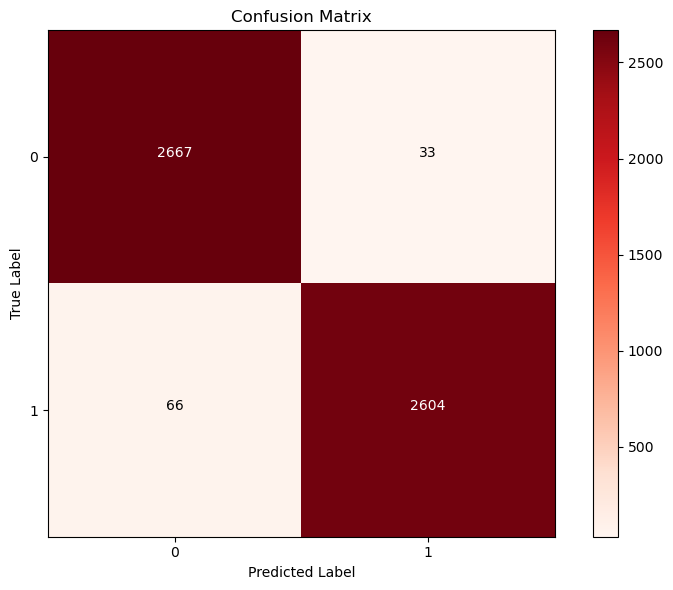

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def display_confusion_matrix(tp, fp, tn, fn):
    # Erstellen der Confusion-Matrix aus TP, FP, TN, FN
    cm = np.array([[tp, fn], 
                   [fp, tn]])

    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Reds)
    plt.title("Confusion Matrix")
    plt.colorbar()

    # Achsenbeschriftungen für Binärklassifikation (0 = Negative, 1 = Positive)
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['0', '1'])
    plt.yticks(tick_marks, ['0', '1'])

    # Einfügen der Werte in die Matrix mit Farbkontrast für bessere Sichtbarkeit
    threshold = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]}", 
                 horizontalalignment="center", 
                 color="white" if cm[i, j] > threshold else "black")

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

# Aufruf der Funktion zur Anzeige der Confusion-Matrix
display_confusion_matrix(tp, fp, tn, fn)


In [15]:
# folder_path = 'D:/Datasets/yolo1_predicted_non_nodule'

# # List all files in the directory
# files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]


In [16]:
# predicted_non_nodule_labels = 'D:/Datasets/yolo1_predicted_non_nodule_labels'


# os.makedirs(predicted_non_nodule_labels, exist_ok=True)


# # Verzeichnis, in dem die Originalbilder und Labels gespeichert sind
# source_directory = 'D:/Datasets/YOLO_1_Dataset/test/labels'

# # Funktion, um die entsprechenden .txt Label-Dateien zu kopieren
# def copy_labels(file_list, source_directory, destination_folder):
#     for file_name in file_list:
#         base_name = os.path.splitext(file_name)[0]  # Ohne Erweiterung
#         label_file = base_name + '.txt'  # Label-Datei mit der gleichen Basis

#         # Prüfen, ob die Label-Datei existiert
#         label_path = os.path.join(source_directory, label_file)
#         if os.path.exists(label_path):
#             # Kopiere das Label in den Zielordner
#             shutil.copy(label_path, os.path.join(destination_folder, label_file))
#             print(f"Kopiert: {label_path} -> {destination_folder}")
#         else:
#             print(f"Label-Datei nicht gefunden für: {file_name}")


# # Labels für predicted_nodule kopieren
# copy_labels(files, source_directory, predicted_non_nodule_labels)

In [17]:
# BASE_DIR_TEST = "D:\Datasets"
# seed = 41
# batch_size = 16
# classes = ["yolo1_predicted_non_nodule", "Non_Nodules"]
# image_size = 128
# scenario = 1

# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)

In [18]:
# test_dataset = CAPS_Productive_Dataset(root_dir=BASE_DIR_TEST, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR_TEST, "Predicted_Nodules"))), classes=classes, scenario=scenario)


## CAPS

In [2]:
BASE_DIR_TEST = "D:/Datasets/Productive_YOLO1"
seed = 41
batch_size = 16
classes = ["Predicted_Nodules", "Non_Nodules"] #Non-nodules werden nicht angeschaut
image_size = 128
scenario = 1

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
test_dataset = CAPS_Productive_Dataset(root_dir=BASE_DIR_TEST, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR_TEST, "Predicted_Nodules"))), classes=classes, scenario=scenario)


In [4]:
len(test_dataset)

2733

In [5]:
test_dataset[0]

(<PIL.Image.Image image mode=RGB size=128x128>,
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.479296688495663090411829052528_crop.jpg')

In [6]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
test_dataset = TransformDataset(test_dataset, transform=transform)


test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Transformiere das cropped_image
# test_dataset = TransformDatasetFinal(cropped_images_dict, transform)




# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [7]:
batch = next(iter(test_loader))
batch

[tensor([[[[-0.1529, -0.1294, -0.1216,  ..., -0.1686, -0.1686, -0.1686],
           [-0.1451, -0.1294, -0.1216,  ..., -0.1608, -0.1608, -0.1529],
           [-0.1451, -0.1373, -0.1294,  ..., -0.1529, -0.1529, -0.1451],
           ...,
           [-0.1137, -0.1137, -0.1137,  ..., -0.0902, -0.0902, -0.0824],
           [-0.1216, -0.1216, -0.1216,  ..., -0.0902, -0.0902, -0.0902],
           [-0.1294, -0.1294, -0.1294,  ..., -0.0980, -0.0902, -0.0902]]],
 
 
         [[[-0.8196, -0.8196, -0.8196,  ..., -0.8980, -0.9137, -0.8980],
           [-0.8275, -0.8275, -0.8275,  ..., -0.9059, -0.9216, -0.9059],
           [-0.8431, -0.8431, -0.8431,  ..., -0.9216, -0.9294, -0.9137],
           ...,
           [-1.0000, -1.0000, -1.0000,  ...,  0.4980,  0.5608,  0.6000],
           [-1.0000, -1.0000, -1.0000,  ...,  0.5529,  0.6157,  0.6627],
           [-1.0000, -1.0000, -1.0000,  ...,  0.5922,  0.6627,  0.7020]]],
 
 
         [[[-0.8275, -0.8353, -0.8431,  ..., -0.1059, -0.0980, -0.0980],
       

In [8]:
TRAIN_ON_GPU = torch.cuda.is_available()
capsule_net = CapsuleNetwork(image_size=image_size, num_classes=len(classes), train_on_gpu=TRAIN_ON_GPU)
checkpoint = torch.load("CAPS_CROPPED/weights/caps_crop.pt")
model_state_dict = checkpoint['model_state_dict']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

capsule_net.load_state_dict(model_state_dict)
capsule_net.to(device)
print(capsule_net)

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (linear_layers): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=16384, bias=True)
      (5): Sigmoid()
    )
  )
)


In [9]:
preds,paths = capsule_net.run_model(test_loader)



Batch number:  0
Batch number:  1
Batch number:  2
Batch number:  3
Batch number:  4
Batch number:  5
Batch number:  6
Batch number:  7
Batch number:  8
Batch number:  9
Batch number:  10
Batch number:  11
Batch number:  12
Batch number:  13
Batch number:  14
Batch number:  15
Batch number:  16
Batch number:  17
Batch number:  18
Batch number:  19
Batch number:  20
Batch number:  21
Batch number:  22
Batch number:  23
Batch number:  24
Batch number:  25
Batch number:  26
Batch number:  27
Batch number:  28
Batch number:  29
Batch number:  30
Batch number:  31
Batch number:  32
Batch number:  33
Batch number:  34
Batch number:  35
Batch number:  36
Batch number:  37
Batch number:  38
Batch number:  39
Batch number:  40
Batch number:  41
Batch number:  42
Batch number:  43
Batch number:  44
Batch number:  45
Batch number:  46
Batch number:  47
Batch number:  48
Batch number:  49
Batch number:  50
Batch number:  51
Batch number:  52
Batch number:  53
Batch number:  54
Batch number:  55
Ba

In [10]:
# Anzahl der 1er zählen
num_ones = preds.count(1)

# Anzahl der 0er zählen
num_zeros = preds.count(0)

print("Anzahl der 1er:", num_ones)
print("Anzahl der 0er:", num_zeros)

Anzahl der 1er: 100
Anzahl der 0er: 2633


In [11]:
torch.save(preds,"preds_caps.pt")

In [12]:
torch.save(paths,"paths_caps.pt")

In [13]:
# Kürzen der Filenames
shortened_paths = [
    path.split('_', 1)[0] + '.' + path.split('.')[-1] for path in paths
]

In [14]:
# Listen für Klassen erstellen
class_1_files = [shortened_paths[i] for i in range(len(shortened_paths)) if preds[i] == 1]
class_0_files = [shortened_paths[i] for i in range(len(shortened_paths)) if preds[i] == 0]

print("Filenames mit Klasse 1:", len(class_1_files))
print("Filenames mit Klasse 0:", len(class_0_files))

Filenames mit Klasse 1: 100
Filenames mit Klasse 0: 2633


In [15]:
class_1_files

['1.3.6.1.4.1.14519.5.2.1.6279.6001.479296688495663090411829052528.jpg',
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.102327112232649985044931869364.jpg',
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.104495950603684654013760022915.jpg',
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.105311559724535680995430937204.jpg',
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.105800557057336206791850195590.jpg',
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.106799695695791823798104511504.jpg',
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.109093749966484103889469286169.jpg',
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.111651254173993911004769162341.jpg',
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.111882982567630687518331842038.jpg',
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.114302699994490297882055097834.jpg',
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.115315257487691348309332921943.jpg',
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.115901477499261100803587904316.jpg',
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.120803656521683518484558976910.jpg',
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.124323070689421

In [16]:
# Ordner erstellen
class_0_folder = 'D:/Datasets/Productiv_CAPS/predicted_nodule'
class_1_folder = 'D:/Datasets/Productiv_CAPS/predicted_non_nodule'

os.makedirs(class_0_folder, exist_ok=True)
os.makedirs(class_1_folder, exist_ok=True)

# Verzeichnis, in dem die Originalbilder gespeichert sind
source_directory = 'D:/Datasets/YOLO_1_Dataset/test/images'

# Funktion, um Dateien mit anderen Erweiterungen zu finden und zu kopieren
def copy_files(file_list, destination_folder):
    for file_name in file_list:
        # Datei ohne die Erweiterung (nur der Name)
        base_name = os.path.splitext(file_name)[0]

        # Suche nach der Datei mit verschiedenen Erweiterungen
        for extension in ['.jpg', '.jpeg', '.JPEG']:
            source_file = os.path.join(source_directory, base_name + extension)
            if os.path.exists(source_file):
                # Datei kopieren
                shutil.copy(source_file, os.path.join(destination_folder, base_name + extension))
                print(f"Kopiert: {source_file} -> {destination_folder}")
                break
        else:
            print(f"Datei nicht gefunden: {file_name}")



In [17]:
copy_files(class_0_files, class_0_folder)


Kopiert: D:/Datasets/YOLO_1_Dataset/test/images\1.3.6.1.4.1.14519.5.2.1.6655.2359.100048574870269820953143768196.jpeg -> D:/Datasets/Productiv_CAPS/predicted_nodule
Kopiert: D:/Datasets/YOLO_1_Dataset/test/images\1.3.6.1.4.1.14519.5.2.1.6655.2359.100072635488116034651642445239.jpeg -> D:/Datasets/Productiv_CAPS/predicted_nodule
Kopiert: D:/Datasets/YOLO_1_Dataset/test/images\1.3.6.1.4.1.14519.5.2.1.6655.2359.100156561188861970258198914981.jpeg -> D:/Datasets/Productiv_CAPS/predicted_nodule
Kopiert: D:/Datasets/YOLO_1_Dataset/test/images\1.3.6.1.4.1.14519.5.2.1.6655.2359.100423729079097357558203729845.jpeg -> D:/Datasets/Productiv_CAPS/predicted_nodule
Kopiert: D:/Datasets/YOLO_1_Dataset/test/images\1.3.6.1.4.1.14519.5.2.1.6655.2359.100436650956340012584392599393.jpeg -> D:/Datasets/Productiv_CAPS/predicted_nodule
Kopiert: D:/Datasets/YOLO_1_Dataset/test/images\1.3.6.1.4.1.14519.5.2.1.6655.2359.100546121805341655431102542094.jpeg -> D:/Datasets/Productiv_CAPS/predicted_nodule
Kopiert: D

In [18]:

copy_files(class_1_files, class_1_folder)

Kopiert: D:/Datasets/YOLO_1_Dataset/test/images\1.3.6.1.4.1.14519.5.2.1.6279.6001.479296688495663090411829052528.jpeg -> D:/Datasets/Productiv_CAPS/predicted_non_nodule
Kopiert: D:/Datasets/YOLO_1_Dataset/test/images\1.3.6.1.4.1.14519.5.2.1.6655.2359.102327112232649985044931869364.jpeg -> D:/Datasets/Productiv_CAPS/predicted_non_nodule
Kopiert: D:/Datasets/YOLO_1_Dataset/test/images\1.3.6.1.4.1.14519.5.2.1.6655.2359.104495950603684654013760022915.jpeg -> D:/Datasets/Productiv_CAPS/predicted_non_nodule
Kopiert: D:/Datasets/YOLO_1_Dataset/test/images\1.3.6.1.4.1.14519.5.2.1.6655.2359.105311559724535680995430937204.jpeg -> D:/Datasets/Productiv_CAPS/predicted_non_nodule
Kopiert: D:/Datasets/YOLO_1_Dataset/test/images\1.3.6.1.4.1.14519.5.2.1.6655.2359.105800557057336206791850195590.jpeg -> D:/Datasets/Productiv_CAPS/predicted_non_nodule
Kopiert: D:/Datasets/YOLO_1_Dataset/test/images\1.3.6.1.4.1.14519.5.2.1.6655.2359.106799695695791823798104511504.jpeg -> D:/Datasets/Productiv_CAPS/predict

In [19]:
predicted_nodule_labels = 'D:/Datasets/Productiv_CAPS/predicted_nodule_labels'
predicted_non_nodule_labels = 'D:/Datasets/Productiv_CAPS/predicted_non_nodule_labels'
  # Ordner für Labels


os.makedirs(predicted_nodule_labels, exist_ok=True)
os.makedirs(predicted_non_nodule_labels, exist_ok=True)


# Verzeichnis, in dem die Originalbilder und Labels gespeichert sind
source_directory = 'D:/Datasets/YOLO_1_Dataset/test/labels'

# Funktion, um die entsprechenden .txt Label-Dateien zu kopieren
def copy_labels(file_list, source_directory, destination_folder):
    for file_name in file_list:
        base_name = os.path.splitext(file_name)[0]  # Ohne Erweiterung
        label_file = base_name + '.txt'  # Label-Datei mit der gleichen Basis

        # Prüfen, ob die Label-Datei existiert
        label_path = os.path.join(source_directory, label_file)
        if os.path.exists(label_path):
            # Kopiere das Label in den Zielordner
            shutil.copy(label_path, os.path.join(destination_folder, label_file))
            print(f"Kopiert: {label_path} -> {destination_folder}")
        else:
            print(f"Label-Datei nicht gefunden für: {file_name}")


# Labels für predicted_nodule kopieren
copy_labels(class_0_files, source_directory, predicted_nodule_labels)
copy_labels(class_1_files, source_directory, predicted_non_nodule_labels)

Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6655.2359.100048574870269820953143768196.txt -> D:/Datasets/Productiv_CAPS/predicted_nodule_labels
Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6655.2359.100072635488116034651642445239.txt -> D:/Datasets/Productiv_CAPS/predicted_nodule_labels
Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6655.2359.100156561188861970258198914981.txt -> D:/Datasets/Productiv_CAPS/predicted_nodule_labels
Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6655.2359.100423729079097357558203729845.txt -> D:/Datasets/Productiv_CAPS/predicted_nodule_labels
Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6655.2359.100436650956340012584392599393.txt -> D:/Datasets/Productiv_CAPS/predicted_nodule_labels
Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6655.2359.100546121805341655431102542094.txt -> D:/Datasets/Productiv_CAP

In [20]:

yolo_predicted_non_nodule_labels = 'D:/Datasets/Productive_YOLO1/predicted_non_nodule_labels'
def count_positives(folder_path):
    false_positive_count = 0  # Leere Dateien
    true_positive_count = 0   # Nicht leere Dateien

    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            
            # Prüfen, ob die Datei leer ist oder nicht
            if os.path.getsize(file_path) == 0:
                false_positive_count += 1  # Leere Datei (False Positive)
            else:
                true_positive_count += 1   # Nicht leere Datei (True Positive)

    return true_positive_count, false_positive_count

def count_negatives(folder_path):
    false_negative_count = 0  # Leere Dateien, die fälschlicherweise negativ sind
    true_negative_count = 0   # Dateien, die korrekt negativ sind

    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            
            # Prüfen, ob die Datei leer ist oder nicht
            if os.path.getsize(file_path) == 0:
                true_negative_count += 1  # Richtige negative Datei (True Negative)
            else:
                false_negative_count += 1 # Falsche negative Datei (False Negative)

    return true_negative_count, false_negative_count

# Beispielaufruf
tp, fp = count_positives(predicted_nodule_labels)
tn_caps, fn_caps = count_negatives(predicted_non_nodule_labels)
tn_yolo, fn_yolo = count_negatives(yolo_predicted_non_nodule_labels)
tn=tn_caps+tn_yolo
fn=fn_caps+fn_yolo
# Berechnung der Metriken
accuracy = (tp + tn) / (tp + fp + tn + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Ergebnisse ausgeben
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

True Positives (TP): 2579
False Positives (FP): 54
True Negatives (TN): 2616
False Negatives (FN): 121
Accuracy: 0.9674
Precision: 0.9795
Recall: 0.9552
F1-Score: 0.9672


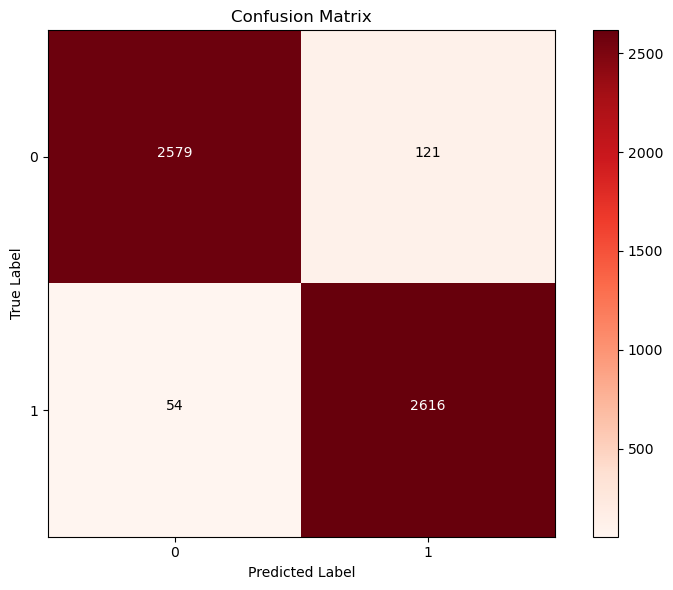

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def display_confusion_matrix(tp, fp, tn, fn):
    # Erstellen der Confusion-Matrix aus TP, FP, TN, FN
    cm = np.array([[tp, fn], 
                   [fp, tn]])

    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Reds)
    plt.title("Confusion Matrix")
    plt.colorbar()

    # Achsenbeschriftungen für Binärklassifikation (0 = Negative, 1 = Positive)
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['0', '1'])
    plt.yticks(tick_marks, ['0', '1'])

    # Einfügen der Werte in die Matrix mit Farbkontrast für bessere Sichtbarkeit
    threshold = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]}", 
                 horizontalalignment="center", 
                 color="white" if cm[i, j] > threshold else "black")

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()



# Aufruf der Funktion zur Anzeige der Confusion-Matrix
display_confusion_matrix(tp, fp, tn, fn)


# NOCHMAL YOLO1

In [48]:
image_folder="D:/Datasets/Productiv_CAPS/predicted_nodule"
label_folder="D:/Datasets/Productiv_CAPS/predicted_nodule_labels"

test_images= [f for f in os.listdir(image_folder) if f.endswith((".jpeg", ".JPEG"))]
test_labels= [f for f in os.listdir(label_folder) if f.endswith((".txt"))]
print(f"Gefundene testbilder: {len(test_images)}")
print(f"Gefundene testlabels: {len(test_labels)}")

image_bbox_pairs = [
                    (os.path.join(image_folder, img), os.path.join(label_folder,img.replace(".jpeg",".txt").replace(".JPEG",".txt")))
                    for img in  test_images
                    if img.replace(".jpeg",".txt").replace(".JPEG",".txt") in test_labels
]
print(f"Gefundene Paare: {len(image_bbox_pairs)}")

Gefundene testbilder: 2633
Gefundene testlabels: 2633
Gefundene Paare: 2633


In [49]:
model=YOLO("YOLO1/1/weights/best.pt")
print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_

In [50]:
predictions_yolo1={}
ground_truths={}

for image_path, bbox_path in image_bbox_pairs:
    image = Image.open(image_path)

    image_np = np.array(image)

    gt_boxes = load_ground_truth(bbox_path, image_np.shape)
    ground_truths[os.path.basename(image_path)] = gt_boxes

    results = model(image_np)

    boxes = results[0].boxes.xyxy.cpu().numpy()
    scores = results[0].boxes.conf.cpu().numpy()
    classes = results[0].boxes.cls.cpu().numpy()

    predictions_yolo1[os.path.basename(image_path)]= {
        "boxes": boxes,
        "scores": scores,
        "classes": classes
    }


0: 512x512 1 class1, 9.0ms
Speed: 2.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 1 class1, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 1 class1, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 1 class1, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 1 class1, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 1 class1, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 1 class1, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 1 class1, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)

0: 

In [51]:
def calculate_iou(box1, box2):
    """
    Berechnet die Intersection over Union (IoU) zwischen zwei Bounding Boxes.
    
    Parameter:
    - box1: [x_min, y_min, x_max, y_max] für die erste Box
    - box2: [x_min, y_min, x_max, y_max] für die zweite Box

    Rückgabewert:
    - IoU-Wert zwischen 0 und 1
    """
    # Koordinaten der Schnittmenge (überlappender Bereich)
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Breite und Höhe der Schnittmenge berechnen
    intersection_width = max(0, x2 - x1)
    intersection_height = max(0, y2 - y1)
    intersection_area = intersection_width * intersection_height

    # Flächen der beiden Boxen berechnen
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Union = Summe der Flächen minus die Schnittfläche
    union_area = box1_area + box2_area - intersection_area

    # Vermeidung von Division durch 0
    return intersection_area / union_area if union_area > 0 else 0
def evaluate_predictions(predictions, ground_truths, iou_threshold=0.5):
    """
    Evaluierung der Bounding Box Vorhersagen anhand der Ground Truth.

    Parameter:
    - predictions: Dictionary mit Vorhersagen (Dateiname -> {'boxes': [...], 'scores': [...], 'classes': [...]})
    - ground_truths: Dictionary mit Ground Truth-Boxen (Dateiname -> [[x1, y1, x2, y2], ...])
    - iou_threshold: Schwellwert für IoU zur Übereinstimmung (Standard = 0.5)

    Rückgabewert:
    - True Positives (TP), False Positives (FP), False Negatives (FN), True Negatives (TN)
    """
    tp, fp, fn, tn = 0, 0, 0, 0

    for image_id, prediction in predictions.items():
        pred_boxes = prediction['boxes']
        gt_boxes = ground_truths.get(image_id, [])
        
        # Fall 1: Weder Vorhersagen noch Ground Truth → True Negative (TN)
        if len(pred_boxes) == 0 and len(gt_boxes) == 0:
            tn += 1
            continue

        # Fall 2: Keine Vorhersage, aber Ground Truth vorhanden → False Negative (FN)
        if len(pred_boxes) == 0 and len(gt_boxes) > 0:
            fn += len(gt_boxes)
            continue

        # Fall 3: Vorhersagen vorhanden, aber keine Ground Truth → False Positive (FP)
        if len(pred_boxes) > 0 and len(gt_boxes) == 0:
            fp += len(pred_boxes)
            continue
        
        # Fall 4: Sowohl Vorhersagen als auch Ground Truth vorhanden
        matched = set()  # Um doppelte Zuordnungen zu vermeiden
        
        for pred_box in pred_boxes:
            best_iou = 0
            best_gt_idx = -1
            
            for idx, gt_box in enumerate(gt_boxes):
                iou = calculate_iou(pred_box, gt_box)
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            # Falls IoU-Schwelle überschritten und Ground Truth nicht bereits gematcht → TP
            if best_iou >= iou_threshold and best_gt_idx not in matched:
                tp += 1
                matched.add(best_gt_idx)
            else:
                fp += 1  # Nicht übereinstimmende Vorhersage ist False Positive

        # Alle nicht gematchten Ground Truth Boxen sind False Negatives
        fn += len(gt_boxes) - len(matched)

    return tp, fp, fn, tn
tp, fp, fn, tn = evaluate_predictions(predictions_yolo1, ground_truths)

tn_caps, fn_caps = count_negatives("D:/Datasets/Productiv_CAPS/predicted_non_nodule_labels")
tn_yolo, fn_yolo = count_negatives("D:/Datasets/Productive_YOLO1/predicted_non_nodule_labels")
print("fn",fn)
print("fn_caps",fn_caps)
print("fn_yolo",fn_yolo)
print("tn",tn)
print("tn_caps",tn_caps)
print("tn_yolo",tn_yolo)


tn=tn_caps+tn_yolo
fn=fn+fn_caps+fn_yolo

accuracy = (tp + tn) / (tp + fp + tn + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Ergebnisse ausgeben
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

fn 180
fn_caps 88
fn_yolo 33
tn 0
tn_caps 12
tn_yolo 2604
True Positives (TP): 2399
False Positives (FP): 264
True Negatives (TN): 2616
False Negatives (FN): 301
Accuracy: 0.8987
Precision: 0.9009
Recall: 0.8885
F1-Score: 0.8946


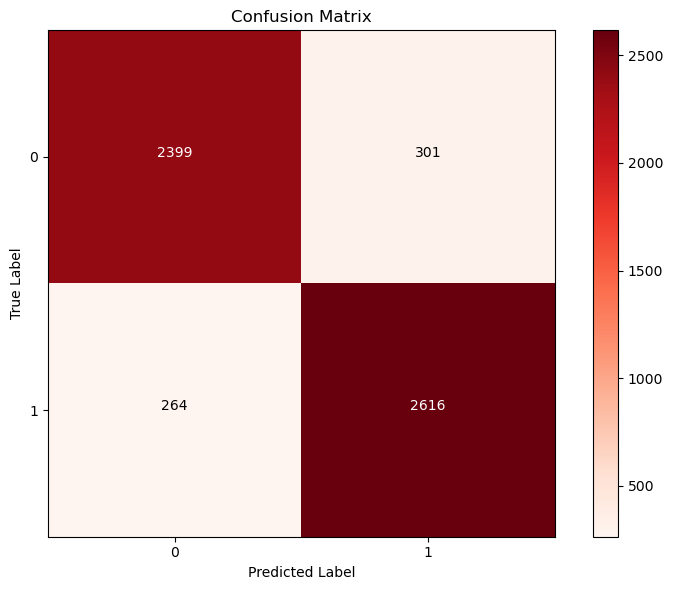

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def display_confusion_matrix(tp, fp, tn, fn):
    # Erstellen der Confusion-Matrix aus TP, FP, TN, FN
    cm = np.array([[tp, fn], 
                   [fp, tn]])

    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Reds)
    plt.title("Confusion Matrix")
    plt.colorbar()

    # Achsenbeschriftungen für Binärklassifikation (0 = Negative, 1 = Positive)
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['0', '1'])
    plt.yticks(tick_marks, ['0', '1'])

    # Einfügen der Werte in die Matrix mit Farbkontrast für bessere Sichtbarkeit
    threshold = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]}", 
                 horizontalalignment="center", 
                 color="white" if cm[i, j] > threshold else "black")

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


# Aufruf der Funktion zur Anzeige der Confusion-Matrix
display_confusion_matrix(tp, fp, tn, fn)

In [53]:
iou_threshold = 0.5  # Mindest-IoU-Wert für eine erfolgreiche Erkennung (True Positive)
scores_list = []     # Liste zur Speicherung der Scores
tp_fp_list = []      # Liste zur Speicherung von TP (1) / FP (0)

# Iteration über alle vorhergesagten Bilder
for img_id, pred in predictions_yolo1.items():
    pred_boxes = pred['boxes']  # Extrahiere vorhergesagte Bounding-Boxen
    pred_scores = pred['scores']  # Extrahiere Confidence-Scores
    
    gt_boxes = ground_truths.get(img_id, [])  # Lade die Ground-Truth-Boxen (falls vorhanden)

    # Falls es keine Ground-Truth für das Bild gibt, sind alle Vorhersagen False Positives (FP)
    if len(gt_boxes) == 0:
        scores_list.extend(pred_scores)  # Füge Scores hinzu
        tp_fp_list.extend([0] * len(pred_scores))  # Füge False Positives hinzu (da keine Ground-Truth)
        continue  # Zum nächsten Bild springen
    
    detected = [False] * len(gt_boxes)  # Markierung, ob Ground-Truth-Boxen schon erkannt wurden
    
    # Vergleiche jede vorhergesagte Box mit allen Ground-Truth-Boxen
    for i, box in enumerate(pred_boxes):
        best_iou = 0
        best_gt_idx = -1

        # Berechne IoU mit jeder Ground-Truth-Box
        for j, gt_box in enumerate(gt_boxes):
            iou = calculate_iou(box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = j
        
        # Wenn die beste Übereinstimmung über dem IoU-Schwellenwert liegt, ist es ein TP
        if best_iou >= iou_threshold and not detected[best_gt_idx]:
            scores_list.append(pred_scores[i])  # Speichere den Score
            tp_fp_list.append(1)  # True Positive (TP)
            detected[best_gt_idx] = True  # Diese Ground-Truth-Box wurde erkannt
        else:
            scores_list.append(pred_scores[i])  # Speichere den Score
            tp_fp_list.append(0)  # False Positive (FP)

# Jetzt haben wir zwei separate Listen
scores_list=np.array(scores_list)
tp_fp_list=np.array(tp_fp_list)


In [54]:
from sklearn.metrics import average_precision_score

average_precision_score(tp_fp_list, scores_list)

0.9563016936356898

## YOLO2

In [96]:
model=YOLO("YOLO1/1/weights/best.pt")
print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_

In [98]:
image_folder="D:/Datasets/Productiv_CAPS/predicted_nodule"
label_folder="D:/Datasets/YOLO_Dataset/test/labels"

test_images= [f for f in os.listdir(image_folder) if f.endswith((".jpeg", ".JPEG"))]
test_labels= [f for f in os.listdir(label_folder) if f.endswith((".txt"))]
print(f"Gefundene testbilder: {len(test_images)}")
print(f"Gefundene testlabels: {len(test_labels)}")
print(os.path.splitext(test_images[0])[0])
image_bbox_pairs = [
                    (os.path.join(image_folder, img), os.path.join(label_folder,img.replace(".jpeg",".txt").replace(".JPEG",".txt")))
                    for img in  test_images
                    if img.replace(".jpeg",".txt").replace(".JPEG",".txt") in test_labels
]
print(f"Gefundene Paare: {len(image_bbox_pairs)}")

Gefundene testbilder: 2633
Gefundene testlabels: 5370
1.3.6.1.4.1.14519.5.2.1.6655.2359.100048574870269820953143768196
Gefundene Paare: 2633


In [99]:
def load_ground_truth(file_path, image_shape):
    h,w = image_shape[:2]
    boxes=[]

    with open(file_path, "r") as f:
        for line in f.readlines():
            class_id,x_center, y_center, width, height = map(float, line.strip().split())

            x_min = int((x_center - width/2)*w)
            y_min = int((y_center - width/2)*h)
            x_max = int((x_center + width/2)*w)
            y_max = int((y_center + width/2)*h)
        
            boxes.append([x_min,y_min,x_max,y_max])
    return boxes

In [100]:
predictions={}
ground_truths={}

for image_path, bbox_path in image_bbox_pairs:
    image = Image.open(image_path)

    image_np = np.array(image)

    gt_boxes = load_ground_truth(bbox_path, image_np.shape)
    ground_truths[os.path.basename(image_path)] = gt_boxes

    results = model(image_np)

    boxes = results[0].boxes.xyxy.cpu().numpy()
    scores = results[0].boxes.conf.cpu().numpy()
    classes = results[0].boxes.cls.cpu().numpy()

    predictions[os.path.basename(image_path)]= {
        "boxes": boxes,
        "scores": scores,
        "classes": classes
    }


0: 512x512 1 class1, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 1 class1, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 1 class1, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 1 class1, 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 1 class1, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 1 class1, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 1 class1, 10.0ms
Speed: 0.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 1 class1, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 5

In [109]:
ground_truths

{'1.3.6.1.4.1.14519.5.2.1.6655.2359.100048574870269820953143768196.jpeg': [[337,
   296,
   362,
   321]],
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.100072635488116034651642445239.jpeg': [[142,
   280,
   201,
   339]],
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.100156561188861970258198914981.jpeg': [[126,
   296,
   180,
   350]],
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.100423729079097357558203729845.jpeg': [[315,
   285,
   396,
   366]],
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.100436650956340012584392599393.jpeg': [[300,
   269,
   352,
   321]],
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.100546121805341655431102542094.jpeg': [[279,
   217,
   347,
   285]],
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.100711050613761855156496841207.jpeg': [[112,
   258,
   168,
   314]],
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.101000900610617184701526787276.jpeg': [[168,
   269,
   202,
   303]],
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.101291121425729144303985968215.jpeg': [[304,
   313,
   390,
   399]],
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.1

In [101]:
predictions

{'1.3.6.1.4.1.14519.5.2.1.6655.2359.100048574870269820953143768196.jpeg': {'boxes': array([[     337.79,      298.65,      360.08,      322.51]], dtype=float32),
  'scores': array([    0.68575], dtype=float32),
  'classes': array([          0], dtype=float32)},
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.100072635488116034651642445239.jpeg': {'boxes': array([[     143.24,       274.3,      203.74,      338.64]], dtype=float32),
  'scores': array([    0.79879], dtype=float32),
  'classes': array([          0], dtype=float32)},
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.100156561188861970258198914981.jpeg': {'boxes': array([[     123.94,      288.28,      178.24,      353.88]], dtype=float32),
  'scores': array([    0.80081], dtype=float32),
  'classes': array([          0], dtype=float32)},
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.100423729079097357558203729845.jpeg': {'boxes': array([[     312.01,      288.82,      393.97,      356.54]], dtype=float32),
  'scores': array([    0.79611], dtype=float32),
  '

In [104]:
len(predictions)

2633

In [108]:
def compute_iou(box1, box2):
    """
    Berechnet Intersection over Union (IoU) für zwei Bounding Boxes.
    Boxformat: [x_min, y_min, x_max, y_max]
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # Flächen von Intersection und Union berechnen
    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    union = box1_area + box2_area - intersection
    
    return intersection / union if union > 0 else 0

def evaluate(predictions, ground_truths, iou_threshold=0.01, score_threshold=0.25):
    """
    Evaluierung der Vorhersagen im Vergleich zu den Ground Truths.
    predictions: Dictionary mit Vorhersagen
    ground_truths: Dictionary mit Ground Truths
    """
    tp, fp, fn, tn = 0, 0, 0, 0

    for image_id, gt_boxes in ground_truths.items():
        pred_boxes = predictions[image_id]['boxes']
        pred_scores = predictions[image_id]['scores']
        
        # Filter Vorhersagen basierend auf Score Threshold
        # pred_boxes = pred_boxes[pred_scores >= score_threshold]
        
        # Fall: Keine Ground Truth und keine Vorhersagen
        if len(gt_boxes) == 0 and len(pred_boxes) == 0:
            tn += 1
            continue

        matched_gt = set()
        for pred_box in pred_boxes:
            # Berechne IoU mit allen Ground Truths
            ious = [compute_iou(pred_box, gt_box) for gt_box in gt_boxes]
            max_iou = max(ious) if ious else 0  # maximaler IoU-Wert für diese Vorhersage
            
            if max_iou >= iou_threshold:
                # True Positive: Eine Ground Truth wurde erkannt
                matched_gt.add(ious.index(max_iou))
            for iou in ious:
                if iou >= iou_threshold:
                    # True Positive: Eine Ground Truth wurde erkann
                    tp += 1
                else:
                    # False Positive: Keine passende Ground Truth gefunden
                    fp += 1

        
        # False Negatives: Nicht erkannte Ground Truths
        fn += len(gt_boxes) - len(matched_gt)

    # Metriken berechnen
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    accuracy = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        "precision": precision,
        "recall": recall,
        "accuracy": accuracy,
        "specificity": specificity,
        "f1_score": f1_score,
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "tn": tn,
    }


results = evaluate(predictions, ground_truths)
print(results)


{'precision': 0.9996164173379364, 'recall': 1.0, 'accuracy': 0.9996164173379364, 'specificity': 0.0, 'f1_score': 0.9998081718779974, 'tp': 2606, 'fp': 1, 'fn': 0, 'tn': 0}


In [114]:
# Einträge mit leeren Boxen filtern
empty_box_entries = {key: value for key, value in predictions.items() if value['boxes'].size == 0}

# Ergebnisse anzeigen
print("Einträge mit leeren Boxen:")
for key, value in empty_box_entries.items():
    print(f"{key}: {value}")

Einträge mit leeren Boxen:


In [103]:
def copy_folders_to_target(folder1, folder2, target_folder):
    # Zielordner erstellen, falls er nicht existiert
    os.makedirs(target_folder, exist_ok=True)
    
    # Helper-Funktion zum Kopieren von Dateien
    def copy_files(source_folder):
        for file_name in os.listdir(source_folder):
            source_path = os.path.join(source_folder, file_name)
            if os.path.isfile(source_path):  # Sicherstellen, dass es sich um eine Datei handelt
                target_path = os.path.join(target_folder, file_name)
                shutil.copy(source_path, target_path)
                print(f"Copied: {source_path} -> {target_path}")

    # Dateien aus beiden Ordnern kopieren
    copy_files(folder1)
    copy_files(folder2)

# Pfade zu den Ordnern
folder1 = "D:/Datasets/Productiv_CAPS/predicted_non_nodule"
folder2 = "D:/Datasets/Productive_YOLO1/Predicted_Non_Nodule"
target_folder = "D:/Datasets/Productive_YOLO2/Predicted_Non_Nodule"

# Kopiervorgang starten
copy_folders_to_target(folder1, folder2, target_folder)


Copied: D:/Datasets/Productiv_CAPS/predicted_non_nodule\1.3.6.1.4.1.14519.5.2.1.6279.6001.479296688495663090411829052528.jpeg -> D:/Datasets/Productive_YOLO2/Predicted_Non_Nodule\1.3.6.1.4.1.14519.5.2.1.6279.6001.479296688495663090411829052528.jpeg
Copied: D:/Datasets/Productiv_CAPS/predicted_non_nodule\1.3.6.1.4.1.14519.5.2.1.6655.2359.102327112232649985044931869364.jpeg -> D:/Datasets/Productive_YOLO2/Predicted_Non_Nodule\1.3.6.1.4.1.14519.5.2.1.6655.2359.102327112232649985044931869364.jpeg
Copied: D:/Datasets/Productiv_CAPS/predicted_non_nodule\1.3.6.1.4.1.14519.5.2.1.6655.2359.104495950603684654013760022915.jpeg -> D:/Datasets/Productive_YOLO2/Predicted_Non_Nodule\1.3.6.1.4.1.14519.5.2.1.6655.2359.104495950603684654013760022915.jpeg
Copied: D:/Datasets/Productiv_CAPS/predicted_non_nodule\1.3.6.1.4.1.14519.5.2.1.6655.2359.105311559724535680995430937204.jpeg -> D:/Datasets/Productive_YOLO2/Predicted_Non_Nodule\1.3.6.1.4.1.14519.5.2.1.6655.2359.105311559724535680995430937204.jpeg
Copi

In [106]:
predicted_non_nodule_labels = 'D:/Datasets/Productive_YOLO2/Predicted_Non_Nodule_Labels'
os.makedirs(predicted_non_nodule_labels, exist_ok=True)
# Verzeichnis, in dem die Originalbilder und Labels gespeichert sind
source_directory = 'D:/Datasets/YOLO_1_Dataset/test/labels'
folder_path = 'D:/Datasets/Productive_YOLO2/Predicted_Non_Nodule'
# List all files in the directory
files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Funktion, um die entsprechenden .txt Label-Dateien zu kopieren
def copy_labels(file_list, source_directory, destination_folder):
    for file_name in file_list:
        base_name = os.path.splitext(file_name)[0]  # Ohne Erweiterung
        label_file = base_name + '.txt'  # Label-Datei mit der gleichen Basis

        # Prüfen, ob die Label-Datei existiert
        label_path = os.path.join(source_directory, label_file)
        if os.path.exists(label_path):
            # Kopiere das Label in den Zielordner
            shutil.copy(label_path, os.path.join(destination_folder, label_file))
            print(f"Kopiert: {label_path} -> {destination_folder}")
        else:
            print(f"Label-Datei nicht gefunden für: {file_name}")


# Labels für predicted_nodule kopieren
copy_labels(files, source_directory, predicted_non_nodule_labels)

Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6279.6001.104507274032170320323347152411.txt -> D:/Datasets/Productive_YOLO2/Predicted_Non_Nodule_Labels
Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6279.6001.104863864417205674007098486529.txt -> D:/Datasets/Productive_YOLO2/Predicted_Non_Nodule_Labels
Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6279.6001.108828997377593078753121028952.txt -> D:/Datasets/Productive_YOLO2/Predicted_Non_Nodule_Labels
Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6279.6001.109466173635014704200062503592.txt -> D:/Datasets/Productive_YOLO2/Predicted_Non_Nodule_Labels
Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6279.6001.109626634592628652877975591041.txt -> D:/Datasets/Productive_YOLO2/Predicted_Non_Nodule_Labels
Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6279.6001.109710522872080626618036223042.tx

In [107]:
def count_tn_fn(folder_path):
    # Zähler initialisieren
    TN = 0  # True Negatives
    FN = 0  # False Negatives

    # Überprüfen, ob der Ordner existiert
    if not os.path.exists(folder_path):
        print(f"Der Ordner {folder_path} existiert nicht.")
        return TN, FN

    # Durch alle Dateien im Ordner iterieren
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path) and file_name.endswith(".txt"):
            # Prüfen, ob die Datei leer ist
            if os.path.getsize(file_path) == 0:
                TN += 1  # Leere Datei -> TN erhöhen
            else:
                FN += 1  # Nicht-leere Datei -> FN erhöhen

    return TN, FN

# Ordnerpfad
folder_path = "D:/Datasets/Productive_YOLO2/Predicted_Non_Nodule_labels"

# Funktion aufrufen und Zähler ausgeben
TN, FN = count_tn_fn(folder_path)
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")


True Negatives (TN): 2616
False Negatives (FN): 121


In [110]:
predicted_non_nodule_labels = 'D:/Datasets/Productiv_CAPS/predicted_nodule_labels'
os.makedirs(predicted_non_nodule_labels, exist_ok=True)
# Verzeichnis, in dem die Originalbilder und Labels gespeichert sind
source_directory = 'D:/Datasets/YOLO_1_Dataset/test/labels'
folder_path = 'D:/Datasets/Productiv_CAPS/predicted_nodule'
# List all files in the directory
files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Funktion, um die entsprechenden .txt Label-Dateien zu kopieren
def copy_labels(file_list, source_directory, destination_folder):
    for file_name in file_list:
        base_name = os.path.splitext(file_name)[0]  # Ohne Erweiterung
        label_file = base_name + '.txt'  # Label-Datei mit der gleichen Basis

        # Prüfen, ob die Label-Datei existiert
        label_path = os.path.join(source_directory, label_file)
        if os.path.exists(label_path):
            # Kopiere das Label in den Zielordner
            shutil.copy(label_path, os.path.join(destination_folder, label_file))
            print(f"Kopiert: {label_path} -> {destination_folder}")
        else:
            print(f"Label-Datei nicht gefunden für: {file_name}")


# Labels für predicted_nodule kopieren
copy_labels(files, source_directory, predicted_non_nodule_labels)

Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6655.2359.100048574870269820953143768196.txt -> D:/Datasets/Productiv_CAPS/predicted_nodule_labels
Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6655.2359.100072635488116034651642445239.txt -> D:/Datasets/Productiv_CAPS/predicted_nodule_labels
Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6655.2359.100156561188861970258198914981.txt -> D:/Datasets/Productiv_CAPS/predicted_nodule_labels
Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6655.2359.100423729079097357558203729845.txt -> D:/Datasets/Productiv_CAPS/predicted_nodule_labels
Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6655.2359.100436650956340012584392599393.txt -> D:/Datasets/Productiv_CAPS/predicted_nodule_labels
Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6655.2359.100546121805341655431102542094.txt -> D:/Datasets/Productiv_CAP

In [117]:
import os

def get_file_list_without_suffix(folder_path, suffix="_crop.jpg"):
    """
    Erstellt eine Liste von Dateinamen ohne einen angegebenen Suffix.
    
    Args:
        folder_path (str): Pfad zum Ordner mit den Dateien.
        suffix (str): Der zu entfernende Suffix (Standard: "_crop.jpg").
    
    Returns:
        list: Liste der Dateinamen ohne den angegebenen Suffix.
    """
    # Überprüfen, ob der Ordner existiert
    if not os.path.exists(folder_path):
        print(f"Ordner existiert nicht: {folder_path}")
        return []

    # Liste erstellen
    file_list = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(suffix):
            base_name = file_name.replace(suffix, "")
            file_list.append(base_name)

    return file_list

# Beispielordnerpfad
folder_path = "D:/Datasets/Productive_YOLO1/Predicted_Nodules"  # Ersetze mit deinem Ordnerpfad

# Liste der Dateien abrufen
file_list = get_file_list_without_suffix(folder_path)

# Ergebnis ausgeben
if file_list:
    print("Dateien ohne '_crop.jpg':")
    for file in file_list:
        print(file)
else:
    print("Keine Dateien gefunden oder der Ordner ist leer.")


Dateien ohne '_crop.jpg':
1.3.6.1.4.1.14519.5.2.1.6279.6001.479296688495663090411829052528
1.3.6.1.4.1.14519.5.2.1.6655.2359.100048574870269820953143768196
1.3.6.1.4.1.14519.5.2.1.6655.2359.100072635488116034651642445239
1.3.6.1.4.1.14519.5.2.1.6655.2359.100156561188861970258198914981
1.3.6.1.4.1.14519.5.2.1.6655.2359.100423729079097357558203729845
1.3.6.1.4.1.14519.5.2.1.6655.2359.100436650956340012584392599393
1.3.6.1.4.1.14519.5.2.1.6655.2359.100546121805341655431102542094
1.3.6.1.4.1.14519.5.2.1.6655.2359.100711050613761855156496841207
1.3.6.1.4.1.14519.5.2.1.6655.2359.101000900610617184701526787276
1.3.6.1.4.1.14519.5.2.1.6655.2359.101291121425729144303985968215
1.3.6.1.4.1.14519.5.2.1.6655.2359.101387392164687470019399118073
1.3.6.1.4.1.14519.5.2.1.6655.2359.101552676343802219174468968616
1.3.6.1.4.1.14519.5.2.1.6655.2359.101634367634299367585297122422
1.3.6.1.4.1.14519.5.2.1.6655.2359.102036617799935254529214401373
1.3.6.1.4.1.14519.5.2.1.6655.2359.102061873219359169760863971555

In [119]:
len(file_list)

2733

In [120]:
# Zielverzeichnis für die kopierten Labels
predicted_non_nodule_labels = 'D:/Datasets/Productive_YOLO1/predicted_nodule_labels'
os.makedirs(predicted_non_nodule_labels, exist_ok=True)

# Verzeichnis mit den Original-Labels
source_directory = 'D:/Datasets/YOLO_1_Dataset/test/labels'
def copy_labels(file_list, source_directory, destination_folder):
    for base_name in file_list:
        label_file = base_name + '.txt'  # Label-Datei mit derselben Basis

        # Prüfen, ob die Label-Datei existiert
        label_path = os.path.join(source_directory, label_file)
        if os.path.exists(label_path):
            # Kopiere das Label in den Zielordner
            shutil.copy(label_path, os.path.join(destination_folder, label_file))
            print(f"Kopiert: {label_path} -> {destination_folder}")
        else:
            print(f"Label-Datei nicht gefunden für: {base_name}")

# Labels kopieren
copy_labels(file_list, source_directory, predicted_non_nodule_labels)

Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6279.6001.479296688495663090411829052528.txt -> D:/Datasets/Productive_YOLO1/predicted_nodule_labels
Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6655.2359.100048574870269820953143768196.txt -> D:/Datasets/Productive_YOLO1/predicted_nodule_labels
Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6655.2359.100072635488116034651642445239.txt -> D:/Datasets/Productive_YOLO1/predicted_nodule_labels
Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6655.2359.100156561188861970258198914981.txt -> D:/Datasets/Productive_YOLO1/predicted_nodule_labels
Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6655.2359.100423729079097357558203729845.txt -> D:/Datasets/Productive_YOLO1/predicted_nodule_labels
Kopiert: D:/Datasets/YOLO_1_Dataset/test/labels\1.3.6.1.4.1.14519.5.2.1.6655.2359.100436650956340012584392599393.txt -> D:/Datasets/Pro